In [1]:
import numpy as np
import astra
from scipy.optimize import newton, root_scalar, minimize
import scipy.sparse as sp
import scipy.linalg

from matplotlib.ticker import MultipleLocator

In [2]:
from MGTomo.utils import mylog, mydiv, myexp
import MGTomo.functions as fcts

from MGTomo.gridop import P, R
from MGTomo import gridop


import time
import numpy as np

import matplotlib.pyplot as plt 
from skimage import data
from skimage.transform import resize
import torch

import pylops

from MGTomo.optimize import orthant_bounds_optimized

In [3]:
import torch
import torch.nn.functional as F
from torch.linalg import matrix_norm

def R_rows_only(input_image):
    kernel_1d = torch.tensor([1, 2, 1], dtype=torch.float32)
    kernel_1d = kernel_1d / kernel_1d.sum()

    # Convert the 1D kernel to a 2D vertical kernel for conv2d
    kernel_2d = kernel_1d[:, None]  # Shape (3, 1)

    # Convert to 4D conv2d weight shape: (out_channels, in_channels, height, width)
    kernel_4d = kernel_2d.unsqueeze(0).unsqueeze(0)


    output_image = F.conv2d(input_image.unsqueeze(0).unsqueeze(0), kernel_4d, stride=(2, 1))

    return output_image.squeeze(0).squeeze(0)


def P_rows_only(input_image):
    kernel_1d = torch.tensor([1, 2, 1], dtype=torch.float32)
    kernel_1d = kernel_1d / kernel_1d.sum()

    # Convert the 1D kernel to a 2D vertical kernel for conv2d
    kernel_2d = kernel_1d[:, None]  # Shape (3, 1)
    
    # Convert to 4D conv2d weight shape: (out_channels, in_channels, height, width)
    kernel_4d = kernel_2d.unsqueeze(0).unsqueeze(0)

    # Apply convolution with bilinear interpolation kernel
    output_image = F.conv_transpose2d(input_image.unsqueeze(0).unsqueeze(0), kernel_4d, stride=(2,1))

    return output_image.squeeze(0).squeeze(0)

In [4]:
def compute_nonzero_elements_of_P_rows_only(input_size):
    # 1D kernel used for row interpolation
    kernel = torch.tensor([1, 2, 1], dtype=torch.float32) / 4.0
    
    n = input_size  # assume square input image of size n x n
    out_n_rows = 2 * n + 1
    out_n_cols = n  # columns stay the same
    
    P_dict = {}
    
    for i in range(n):         # input row
        for j in range(n):     # input col
            input_coords = (i, j)
            
            if input_coords not in P_dict:
                P_dict[input_coords] = []
            
            # Each input row i maps to output rows 2*i to 2*i+2 (stride 2)
            out_j = j  # column stays the same
            for ki in range(3):  # 3-tap kernel
                out_i = 2 * i + ki
                
                if 0 <= out_i < out_n_rows:
                    output_coords = (out_i, out_j)
                    P_dict[input_coords].append(output_coords)
    
    return P_dict

In [5]:
np.int = np.int32
fine_dim = 31

max_levels = 1
maxIter = [1,1,10]
num_proj = 120
angles = np.linspace(0, np.pi, num_proj, endpoint=False)  # Projection angles

det_count = fine_dim

geometry = astra.create_proj_geom('parallel', 1.0, det_count, angles)
vol_geom = astra.create_vol_geom(fine_dim, fine_dim)
proj_id = astra.create_projector('line', geometry, vol_geom)
matrix_id = astra.projector.matrix(proj_id)

H = [sp.csr_matrix(astra.matrix.get(matrix_id))]

P_nonzero = []

for i in range(1, max_levels+1):
    coarse_dim = fine_dim//2
    # num_proj = num_proj//2
    det_count = coarse_dim
    angles = np.linspace(0, np.pi, num_proj, endpoint=False)  # Projection angles

    P_nonzero.append(compute_nonzero_elements_of_P_rows_only(coarse_dim))

    geometry = astra.create_proj_geom('parallel', 1.0, det_count, angles)
    vol_geom = astra.create_vol_geom(coarse_dim, coarse_dim)
    proj_id = astra.create_projector('line', geometry, vol_geom)
    matrix_id = astra.projector.matrix(proj_id)

    P_nonzero.append(gridop.compute_nonzero_elements_of_P(coarse_dim))

    Hnew = astra.matrix.get(matrix_id)
    H.append(sp.csr_matrix(Hnew))

    fine_dim = coarse_dim

In [6]:
shapes = [(31,120), (15,120)]

In [7]:
def objective(x, H):
    X = np.diag(x)
    FIM = H @ X @ H.T
    sgn, logdet = np.linalg.slogdet(FIM)
    return - logdet

In [8]:
def derivative_obj(x, H):
    X = sp.diags(x)
    HXHT = (H @ X @ H.T).tocsc()

    # #HXHT_inv = sp.linalg.splu(HXHT).solve(sp.eye(HXHT.shape[0]).tocsc())

    # Perform LU decomposition
    lu = sp.linalg.splu(HXHT)  

    n = HXHT.shape[0]
    C_diag = np.zeros(H.shape[1])  # Store diagonal values only

    for i in range(H.shape[1]):
        #print(i)
        ei = np.zeros(H.shape[1])
        ei[i] = 1  # Unit vector for the i-th column
        HXHT_inv_Hi = lu.solve(H @ ei)  # Solve for H[:, i]
        C_diag[i] = (H[:, i].T @ HXHT_inv_Hi).item()  # Extract diagonal entry

    return - C_diag

def deriv_geom(x):
    return -1/x

def newton_equation(theta, c, eq_constraint):
    return np.sum(1 / (c + theta)) - eq_constraint

def stable_netwon_equation(c, theta, eq_constraint):
    safe_c_theta = np.clip(np.abs(c + theta), 1e-10, None)  # Avoid log(0)
    return np.sum(np.exp(-np.log(safe_c_theta))) - eq_constraint  # Uses log instead of division

def newton_derivative(theta, c, eq_constraint):
    max_val=np.ones_like(c)*1e-10
    return -np.sum(1 / np.maximum((c + theta) ** 2, max_val))

def stable_netwon_derivative(c, theta, eq_constraint):
    safe_c_theta = np.clip(np.abs(c + theta), 1e-10, None)  # Avoid log(0)
    return -np.sum(np.exp(-2 * np.log(safe_c_theta)))  # Uses log instead of division


In [9]:
fh = lambda x: objective(x, H[0].T)

In [10]:
x = np.ones(3720)/3720
solution_vec_SL = []
theta = 100

iteration_times_SL = []
iteration_times_SL.append(0)

solution_vec_SL.append(x)

print('-1', fh(x))

for i in range(50):
    iteration_start_time_SL = time.time()  # Start timing for this iteration
    c = derivative_obj(x, H[0].T) - deriv_geom(x)
    res = root_scalar(stable_netwon_equation, bracket=[-np.min(c), 1e5], args=(c, 1), x0 =  theta, fprime=stable_netwon_derivative, method="bisect")
    theta = res.root
    x = 1/(c+theta)
    print(i, fh(x))
    angle_scores = np.array([
    np.sum(x[i * 31:(i + 1) * 31]) for i in range(123)
    ])
    iteration_end_time_SL = time.time()  # End timing for this iteration
    iteration_time_SL = iteration_end_time_SL - iteration_start_time_SL  # Calculate elapsed time for this iteration
    iteration_times_SL.append(iteration_time_SL)
    
    solution_vec_SL.append(x)  
    
    # angle_scores = np.array([
    # np.sum(x[i * 31:(i + 1) * 31]) for i in range(123)
    # ])
    # print(np.argsort(angle_scores)[-10:])

-1 3994.6059003793457
0 3979.838730026722
1 3970.1038971333064
2 3963.614738809074
3 3959.1718695105474
4 3956.029372100546
5 3953.7360556326166
6 3952.0131978232052
7 3950.6844957814715
8 3949.6358010730937
9 3948.7912689495734
10 3948.0991009829254
11 3947.522966142577
12 3947.0367653288195
13 3946.621360398967
14 3946.2624688493397
15 3945.949266224629
16 3945.6734324845065
17 3945.428487118628
18 3945.209318353045
19 3945.011846089645
20 3944.832778360017
21 3944.669433583727
22 3944.5196092173583
23 3944.381483186722
24 3944.2535386611466
25 3944.1345056962296
26 3944.0233153282047
27 3943.919063079847
28 3943.820979734096
29 3943.7284078110924
30 3943.6407825663077
31 3943.5576165913153
32 3943.478487291426
33 3943.403026663102
34 3943.330912911414
35 3943.2618635423755
36 3943.195629640791
37 3943.131991104678
38 3943.070752655439
39 3943.0117404802763
40 3942.954799393038
41 3942.8997904226217
42 3942.8465887558255
43 3942.795081975647
44 3942.7451685472092
45 3942.696756511788

In [11]:
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) for i in range(len(iteration_times_SL))]

In [12]:
angle_scores_SL = np.array([
    np.sum(x[i * 31:(i + 1) * 31]) for i in range(120)
])
best_angle_indices_SL = np.argsort(angle_scores_SL)[-10:]

In [13]:
angles_SL = np.concatenate([
    np.linspace(0, np.pi, 5, endpoint=False),
    np.linspace(0, np.pi, 120, endpoint=False)[best_angle_indices_SL]
])

# Multilevel

In [14]:
def armijo_linesearch(f, x: torch.tensor, d: torch.tensor, dfx, a=4, r = 0.5, c = 1e-1):
    fx = f(x)
    # d = d/np.linalg.norm(d)
    # print(sum(d))
    dgk = np.sum(dfx * d)

    # print(dgk)
    
    #assert dgk <= 0, 'd needs to be a descent direction (dgk = %.5e)' % dgk
    
    if dgk == 0.:
        return x, 0.
    
    while True:
        x_new = x + a * d
        #x_new_projected = simplex_projection(x_new)
        
        #f_new = f(x_new_projected)
        f_new = f(x_new)
        
        if f_new <= fx + a * c * dgk:
            #x_new = simplex_projection(x_new)
            break
        
        a *= r
        if a <= 1e-7:
            print('Armijo step too small, a = 0')
            return x, 0.
    return x_new, a

In [15]:
def coarse_condition(eta, y, y_last = None):
    if y_last is not None:
        y_diff_norm = np.linalg.norm(y_last - y)
        y_norm = np.linalg.norm(y)
        return (y_diff_norm >= eta * y_norm)
    else:
        return True

In [16]:
def MLO(y, last_pts: list, l=0, kappa = 0.45, eps = 0.02, theta = 30):
    if coarse_condition(eps, y, last_pts[l]):
        y_tensor = torch.Tensor(y.reshape(shapes[l]))
        x_tensor = R_rows_only(y_tensor)
        x = x_tensor.numpy().flatten()
        y0 = y
        dfhy0 = derivative_obj(y, H[l].T)
    
        last_pts[l] = y
        print(l, ' : coarse correction activated')
    
        x0 = x
        dfHx0 = derivative_obj(x, H[l+1].T)

        kappa = R_rows_only((torch.Tensor(dfhy0.reshape(shapes[l])))).numpy().flatten() - dfHx0
        S = np.sum(x0)

        lH = orthant_bounds_optimized(y_tensor, x_tensor, 1, torch.zeros_like(y_tensor), P_nonzero[l]).numpy().flatten()
        dfHx = dfHx0

        for i in range(maxIter[l+1]):
            c = dfHx + kappa - deriv_geom(x)
            upper_bound = np.max(1/(lH+1e-4) - c)
            res = root_scalar(stable_netwon_equation, bracket=[-np.min(c), upper_bound], args=(c, S), x0 =  theta, fprime=stable_netwon_derivative, method="bisect")
            theta = res.root
            x = 1/(c+theta)
            #print('xmin - lH: ', np.min(x-lH))
            #print('xsum: ', np.sum(x))
            #dfHx = derivative_obj(x,H[l+1].T)

        #print(np.linalg.norm(derivative_obj(x, H[l+1]) + kappa))
        #print('descent_direction' , np.sum(dfHx0 * (x-x0)))

        # if l < max_levels-1:
        #     x, last_pts = MLO(x, last_pts, l+1)

        d = P_rows_only((torch.Tensor((x-x0).reshape(shapes[l+1])))).numpy().flatten()

        # print('descent_direction', np.sum(dfhy0*d))

        #z = simplex_armijo(fh, y0, d)
        z, a = armijo_linesearch(fh, y0, d, dfhy0)
        # print('zmin', z.min())
        # print('z sum:', np.sum(z))
        # print(a)
        # print(fh(z))
        y = z
        # angle_scores = np.array([
        # np.sum(z[i * 31:(i + 1) * 31]) for i in range(123)
        # ])
        # print(np.argsort(angle_scores)[-15:])
    else: 
        print(l, ' : coarse correction not activated')
    
    # theta = 100
    for i in range(maxIter[l]):
        c = derivative_obj(y, H[l].T) - deriv_geom(y)
        res = root_scalar(stable_netwon_equation, bracket=[-np.min(c), 1e5], args=(c, 1), x0 =  theta, fprime=stable_netwon_derivative, method="bisect")
        theta = res.root
        y = 1/(c+theta)
    return y, last_pts

In [17]:
last_pts = [None]*(max_levels+1)
solution_vec_ML = []
x = np.ones(3720)/3720
solution_vec_ML.append(x)
print('-1', fh(x))
#theta = 100

iteration_times_ML = []
iteration_times_ML.append(0)

for i in range(30):
    iteration_start_time_ML = time.time()
    
    x, ylast = MLO(x,last_pts)
    iteration_end_time_ML = time.time()
    iteration_time_ML = iteration_end_time_ML - iteration_start_time_ML
    iteration_times_ML.append(iteration_time_ML)

    solution_vec_ML.append(x)  
    fx = fh(x)
    print(f"Iteration {i}: {fx} - Time: {iteration_time_ML:.6f} seconds")

overall_time_ML = sum(iteration_times_ML) 

print(f"Overall time for all iterations: {overall_time_ML:.6f} seconds")

cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

-1 3994.6059003793457
0  : coarse correction activated
Iteration 0: 3968.369792816717 - Time: 7.754761 seconds
0  : coarse correction activated
Iteration 1: 3958.066706813184 - Time: 7.747934 seconds
0  : coarse correction activated
Iteration 2: 3953.185141457392 - Time: 7.728928 seconds
0  : coarse correction activated
Iteration 3: 3950.451263616602 - Time: 7.747500 seconds
0  : coarse correction activated
Iteration 4: 3948.724125254356 - Time: 7.730965 seconds
0  : coarse correction activated
Iteration 5: 3947.5345238563273 - Time: 7.724930 seconds
0  : coarse correction not activated
Iteration 6: 3947.0040083136278 - Time: 3.340434 seconds
0  : coarse correction activated
Iteration 7: 3946.2429944615747 - Time: 7.735723 seconds
0  : coarse correction not activated
Iteration 8: 3945.8999425830275 - Time: 3.336384 seconds
0  : coarse correction activated
Iteration 9: 3945.3648142075685 - Time: 7.794219 seconds
0  : coarse correction not activated
Iteration 10: 3945.1265878964127 - Tim

In [18]:
angle_scores_ML = np.array([
    np.sum(x[i * 31:(i + 1) * 31]) for i in range(120)
])
best_angle_indices_ML = np.argsort(angle_scores_ML)[-10:]

In [19]:
angles_ML = np.concatenate([
    np.linspace(0, np.pi, 5, endpoint=False),
    np.linspace(0, np.pi, 120, endpoint=False)[best_angle_indices_ML]
])

# Least Squares Setup

In [20]:
# from PIL import Image
# import numpy as np

# # Load and convert to grayscale
# img = Image.open("Mario.png")
# gray = img.convert("L")

# # Resize FIRST, using nearest neighbor to avoid interpolation
# resized = gray.resize((31, 31), resample=Image.NEAREST)

# # Now reduce grayscale levels manually (same as before)
# arr = np.array(resized)
# num_levels = 8
# arr_scaled = (arr / 255) * (num_levels - 1)
# arr_reduced = (arr_scaled.round() * (255 / (num_levels - 1))).astype(np.uint8)
# final_img = Image.fromarray(arr_reduced)

# # Save or show
# final_img.save("Mario_small_gray_6levels.png")

In [21]:
from PIL import Image

image = Image.open('Mario_small_gray_8levels.png')
image_np = np.array(image)
x_orig = np.array(image.resize((31,31)))/255
image_flat = x_orig.flatten()

vol_geom = astra.create_vol_geom(31, 31)

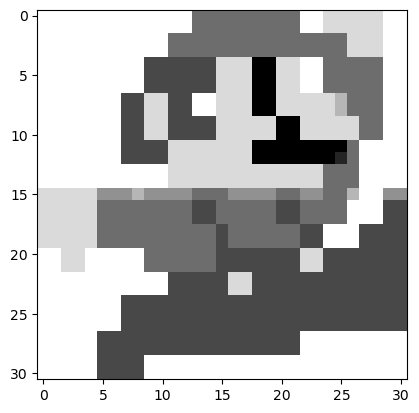

In [22]:
plt.imshow(x_orig, cmap='gray')

In [23]:
geometry_SL = astra.create_proj_geom('parallel', 1.0, 31, angles_SL)
proj_id_SL = astra.create_projector('line', geometry_SL, vol_geom)
matrix_id_SL = astra.projector.matrix(proj_id_SL)

H_optimized_SL = sp.csr_matrix(astra.matrix.get(matrix_id_SL))
b_optimized_SL = H_optimized_SL @ image_flat

In [24]:
geometry = astra.create_proj_geom('parallel', 1.0, 31, np.linspace(0, np.pi, 15, endpoint=False))
proj_id = astra.create_projector('line', geometry, vol_geom)
matrix_id = astra.projector.matrix(proj_id)

H_uniform = sp.csr_matrix(astra.matrix.get(matrix_id))
b = H_uniform @ image_flat

In [25]:
geometry = astra.create_proj_geom('parallel', 1.0, 31, angles_ML)
proj_id = astra.create_projector('line', geometry, vol_geom)
matrix_id = astra.projector.matrix(proj_id)

H_optimized_ML = sp.csr_matrix(astra.matrix.get(matrix_id))
b_optimized_ML = H_optimized_ML @ image_flat

In [26]:
x_reconstructed = sp.linalg.lsmr(H_uniform, b)[0]
x_reconstructed_optimized_SL = sp.linalg.lsmr(H_optimized_SL, b_optimized_SL)[0]
x_reconstructed_optimized_ML = sp.linalg.lsmr(H_optimized_ML, b_optimized_ML)[0]

In [27]:
np.linalg.norm(image_flat - x_reconstructed_optimized_SL)

3.200109127549678

In [28]:
np.linalg.norm(image_flat - x_reconstructed_optimized_ML)

3.1944033660712594

In [29]:
np.linalg.norm(image_flat - x_reconstructed)

3.592200732040955

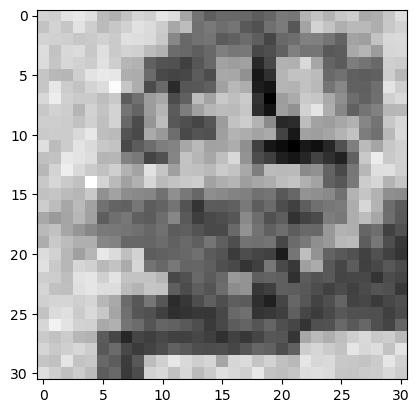

In [30]:
plt.imshow(x_reconstructed_optimized_SL.reshape(31,31), cmap = 'gray')

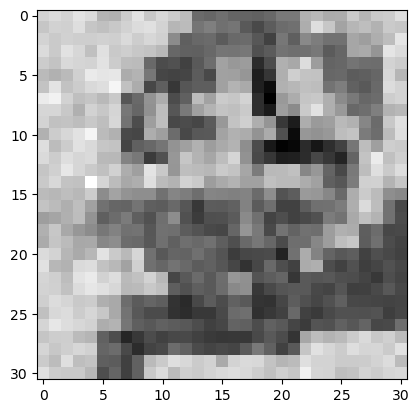

In [31]:
plt.imshow(x_reconstructed_optimized_ML.reshape(31,31), cmap = 'gray')

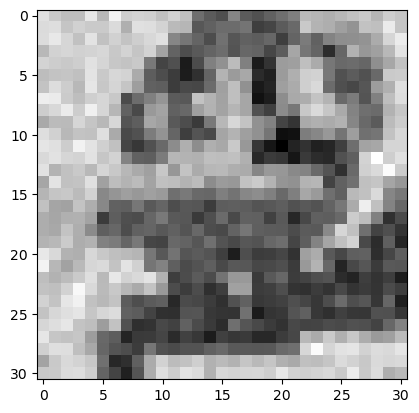

In [32]:
plt.imshow(x_reconstructed.reshape(31,31), cmap = 'gray')

In [33]:
plt.imsave('mario_SL.png', x_reconstructed_optimized_SL.reshape(31,31), cmap = 'gray')

In [34]:
plt.imsave('mario_ML.png', x_reconstructed_optimized_ML.reshape(31,31), cmap = 'gray')

In [35]:
plt.imsave('mario_uniform.png', x_reconstructed.reshape(31,31), cmap = 'gray')

In [36]:
fval_ML = [fh(x) for x in solution_vec_ML]
fval_SL = [fh(x) for x in solution_vec_SL]

fval_ML_normalized = [val / fval_ML[0] for val in fval_ML]
fval_SL_normalized = [val / fval_SL[0] for val in fval_SL]

In [37]:
plt.rcParams.update({
    'legend.fontsize': 14,  # Legend font size
    'axes.labelsize': 14,   # Axis label font size
    'xtick.labelsize': 12,  # X-axis tick label size
    'ytick.labelsize': 12   # Y-axis tick label size
})

plt.rcParams['image.cmap'] = 'viridis'

In [38]:
cumaltive_times_SL = [sum(iteration_times_SL[:i+1]) + 0.7 for i in range(len(iteration_times_SL))]
cumaltive_times_ML = [sum(iteration_times_ML[:i+1]) for i in range(len(iteration_times_ML))]

In [39]:
cumaltive_times_ML

[0,
 7.754760503768921,
 15.502694845199585,
 23.23162293434143,
 30.97912311553955,
 38.71008777618408,
 46.435017824172974,
 49.77545142173767,
 57.51117420196533,
 60.84755778312683,
 68.64177680015564,
 72.01915001869202,
 75.39694166183472,
 83.24827003479004,
 86.64059114456177,
 90.00899600982666,
 93.37322497367859,
 101.2014524936676,
 104.58167266845703,
 107.96219992637634,
 111.32463693618774,
 114.6848349571228,
 122.53112959861755,
 125.90219187736511,
 129.27181196212769,
 132.6018717288971,
 135.95254611968994,
 139.27977323532104,
 142.6097433567047,
 150.31986451148987,
 153.6510238647461]

TypeError: only integer scalar arrays can be converted to a scalar index

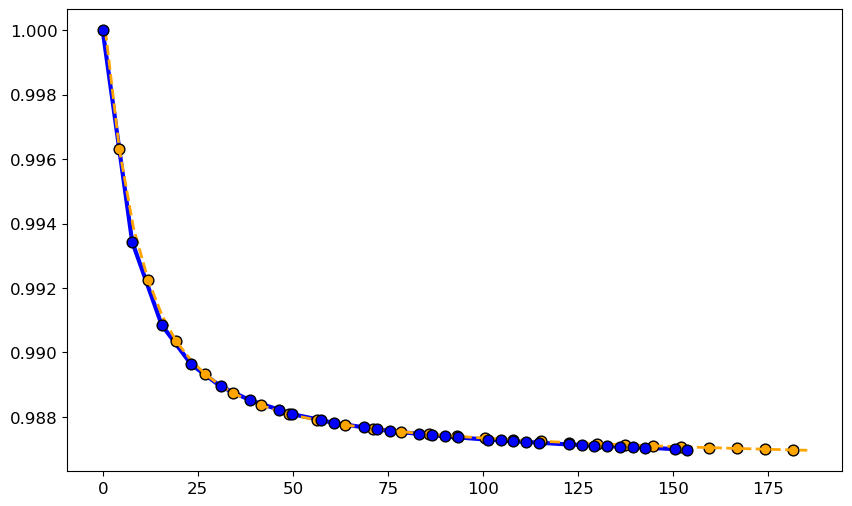

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(cumaltive_times_ML, fval_ML_normalized, linestyle='-', linewidth=3, label='ML', color='blue', zorder=1)
plt.plot(cumaltive_times_SL, fval_SL_normalized, linestyle='--', linewidth=2, label='SL', color='orange')

highlight_every_SL = 2
highlight_every_ML = 1

non_coarse = np.concatenate([[10,11,13,14,15,29], np.arange(17,28)])

plt.scatter(cumaltive_times_ML[::highlight_every_ML], fval_ML_normalized[::highlight_every_ML], 
            color='blue', edgecolors='black', s=60, marker='o', label="1 iter", zorder=2)

plt.scatter(cumaltive_times_SL[1::highlight_every_SL], fval_SL_normalized[1::highlight_every_SL], 
            color='orange', edgecolors='black', s=60, marker='o', label="2 iters")

plt.scatter(cumaltive_times_ML[np.concatenate([np.array([10, 11, 13, 14, 15, 29]), np.arange(17, 28)])], fval_ML_normalized[np.concatenate([np.array([10, 11, 13, 14, 15, 29]), np.arange(17, 28)])], 
            color='red', edgecolors='black', s=60, marker='o', zorder=2)


#plt.ylim(bottom=0.15*10e-6)
plt.xlim(left=0, right=151)
plt.grid(True, linestyle='--', color='gray', alpha=0.3)
plt.legend(fontsize=12, loc='best')
plt.gca().yaxis.set_major_locator(MultipleLocator(0.004))
plt.tight_layout()
plt.savefig('mario_CPU.png', format='png', dpi=300, transparent=True)
plt.show()

In [ ]:
np.concatenate([[10,11,13,14,15,29], np.arange(17,28)])

array([10, 11, 13, 14, 15, 29, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [ ]:
import numpy as np

# Convert to arrays if not already
solution_vec_ML = [np.array(x) for x in solution_vec_ML]
solution_vec_SL = [np.array(x) for x in solution_vec_SL]

# Reference: final solution
ref_ML = solution_vec_ML[-1]
ref_SL = solution_vec_SL[-1]

# Relative errors over iterations (using L2 norm)
rel_error_ML = [np.linalg.norm(x - ref_ML) / np.linalg.norm(ref_SL) for x in solution_vec_ML]
rel_error_SL = [np.linalg.norm(x - ref_SL) / np.linalg.norm(ref_SL) for x in solution_vec_SL]


In [ ]:
# Assume x is your optimized vector of shape (120 * 31,)
num_angles = 120
num_detectors = 31

# Reshape x into a matrix of shape (angles, detectors)
X = x.reshape((num_angles, num_detectors))

# Normalize the matrix to make values relative
X_normalized = X / np.sum(X)

# Sum across detectors to get an importance score per angle
angle_scores = np.sum(X_normalized, axis=1)

# (Optional) Sort angles by importance
sorted_indices = np.argsort(angle_scores)[::-1]
sorted_angles = sorted_indices  # or map to actual angle values if available


In [ ]:
sorted_angles

array([117,  57,   3,  63,   5, 115,  65,  55,  64,  56,   4, 116,   7,
        53,  67, 113,  10, 110,  50,  70,  42,  18,  78, 102, 112,  52,
       101,  68,  41,   8,  79,  19,  72,   9,  69,  48, 111, 108,  12,
        39,  90,  81,  51,  31, 109,  21,  99,  71,  30,  49, 106,  11,
        74,  46,  95,  14,  25,  88,  85,  83,  29,  91,  23,  97,  93,
        37, 103,  32,  17,  35,  33,  89,  16,  87, 104,  77,  62,  15,
        44,   2,  28,  58, 118,  80,  40,  92,  76,  75,  45,  24,  38,
       100,  43,  27, 105,  47,  22,  20,  98,  82,  96,  73,  36,  26,
        13, 107,  84,  54,  66,  86, 114,   6,  94,  34,  61,   0,  59,
         1, 119,  60])

In [ ]:
from numpy.linalg import svd

# Use the reshaped matrix from before
X = x.reshape((num_angles, num_detectors))

# Apply SVD: X ≈ U S V^T
U, S, VT = svd(X, full_matrices=False)

# Take the first left singular vector (dominant mode for angles)
angle_svd_scores = U[:, 0] * S[0]  # Scale to match original magnitude

# (Optional) Normalize or rank
angle_svd_scores = np.abs(angle_svd_scores)
sorted_svd_indices = np.argsort(angle_svd_scores)[::-1]


In [ ]:
sorted_svd_indices[:15]

array([ 57, 117,   3,  63, 115,   5,  64,   7,  56,   4,  53, 116,  55,
        65,  67])

In [ ]:
np.linspace(0, np.pi, 120, endpoint=False)[sorted_svd_indices][:15]

array([1.49225651, 3.06305284, 0.07853982, 1.64933614, 3.01069296,
       0.13089969, 1.67551608, 0.18325957, 1.46607657, 0.10471976,
       1.38753676, 3.0368729 , 1.43989663, 1.70169602, 1.7540559 ])